# Init the libraries

In [2]:
!pip install gymnasium

In [3]:
# Imports
from IPython.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import random
import time
from statistics import mean

import gymnasium as gym
import numpy as np
from gymnasium import spaces
from matplotlib import pyplot as plt

# Grid World environment

In [4]:
# Custom 2D GridWorld Enviroment
class GridWorld(gym.Env):
    metadata = {'render.modes': ['console']}

    # actions available
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3

    def __init__(self, width, height, reward_type="sparse", obstacles=False, verbose=False):
        super(GridWorld, self).__init__()
        self.ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]                         # Mapping of the actions
        self.num_actions = 4

        self.width = width
        self.height = height
        self.size = width * height                                                  # Size of the grid world
        self.num_states = self.size                                                 # States are computed (width * height)
        self.num_obstacles = int((width + height) /2)                               # Number of obstacles present in our Grid
        self.end_state = np.array([height - 1, width - 1], dtype=np.uint8)          # Goal state = Bottom right cell

        self.action_space = spaces.Discrete(4)                                      # Actions space of agent : up, down, left and right
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])    # Observation : Cell indices in the grid

        if obstacles:
            self.num_obstacles = int((width+height)/2)
        else:
            self.num_obstacles = 0

        self.obstacles = np.zeros((height, width))                                  # Initialize the obstacles as a Grid with all zeros

        self.verbose = verbose                                                      # If we want to print out stuff

        self.reward_type = reward_type

        """
        Looping for the number of obstacles, we take a random number between height and width
        and until the two numbers are not (0, 0) -> Because it's the goal, we keep on looping.
        When we've found two suitable numbers, we put 1 in the Obstacles grid at coords height/width.
        """
        for i in range(self.num_obstacles):
            obstacle = random.randrange(height) , random.randrange(width)
            while obstacle == (0, 0):
                obstacle = random.randrange(height), random.randrange(width)
            self.obstacles[obstacle] = 1

        self.num_steps = 0
        self.max_steps = height * width

        self.current_state = np.zeros((2), np.uint8) # Initial state = [0,0]

        self.directions = np.array([
            [-1, 0], # UP
            [0, -1], # LEFT
            [1, 0],  # DOWN
            [0, 1]   # RIGHT
        ])

    def transition_function(self, s, a):
        s_prime =  np.zeros((2), np.uint8)
        s_prime = s + self.directions[a, :]

        # Now we check if the agent is going out of the boundaries.
        #   - If I take state[0], I'm working on the rows.
        #   - If I take state[1], I'm working on the columns.
        if(s_prime[0] < 0 or s_prime[0] >= self.height):
            if(self.verbose):
                print("Agent is going outside of the grid. Staying in the same cell")
            return s
        if(s_prime[1] < 0 or s_prime[1] >= self.width):
            if(self.verbose):
                print("Agent is going outside of the grid. Staying in the same cell")
            return s
        
        # Check obstacles for the agent.
        # If the agent new coordinates are in the coordinates of an obstacle, exit.
        if(self.obstacles[s_prime[0], s_prime[1]] == 1):
            print("Agent is hitting an obstacle. Staying in the same cell")
            return s            
    
        return s_prime # We simply return s_prime

    def reward_function(self,s):
        r = -1 # By default, reward is -1

        if (s == self.end_state).all(): # If agent is in goal state
            if self.reward_type == "sparse":
                r = 100
            else:
                r = 1 / (np.sum((self.end_state - s))+0.000001)

        return r

    def termination_condition(self, s):
        truncated = self.num_steps >= self.max_steps
        terminated = False
        
        if(truncated):
            if(self.verbose):
                print("Maximum steps reached. Exiting.")
            terminated = True
        if(s == self.end_state).all():
            if(self.verbose):
                print("Agent is in the goal state. Let's end the loop.")
            terminated = True

        return terminated, truncated

    def step(self, action):
        s_prime = self.transition_function(self.current_state, action)
        reward = self.reward_function(s_prime)
        terminated, truncated = self.termination_condition(s_prime)

        self.current_state = s_prime
        self.num_steps += 1

        return self.current_state, reward, terminated, truncated, None

    def render(self):
        '''
            render the state
        '''

        row = self.current_state[0]
        col = self.current_state[1]

        for r in range(self.height):
            for c in range(self.width):
                if r == row and c == col:
                    print("| A ", end='')
                elif r == self.end_state[0] and c == self.end_state[1]:
                    print("| G ", end='')
                else:
                    if self.obstacles[r,c] == 1:
                        print('|///', end='')
                    else:
                        print('|___', end='')
            print('|')
        print('\n')

    def reset(self):
        self.current_state = np.zeros((2), np.uint8)
        self.num_steps = 0

        return self.current_state

    def close(self):
        pass

class NonDeterministicGridWorld(GridWorld):
    def __init__(self, width, height, p=0.8, reward_type="sparse", obstacles=False, verbose=False):
        super(NonDeterministicGridWorld, self).__init__(width, height, reward_type, obstacles)
        self.probability_right_action = p
        self.verbose = verbose

    def transition_function(self, s, a):
        if(self.verbose):
            print("Original action to perform:", self.ACTION_NAMES[a])
        s_prime = s + self.directions[a, :]

        # With probability 1 - p, we have a diagonal movement
        # random.random() returns a number between 0 and 1
        if random.random() <= 1 - self.probability_right_action:
            if random.random() < 0.5:
                if(self.verbose):
                    print(F"Actual action performed: {self.ACTION_NAMES[a]} + {self.ACTION_NAMES[(a+1) % self.num_actions]}")
                s_prime = s_prime + self.directions[(a+1) % self.num_actions, :]
            else:
                if(self.verbose):
                    print(F"Actual action performed: {self.ACTION_NAMES[a]} + {self.ACTION_NAMES[(a-1) % self.num_actions]}")
                s_prime = s_prime + self.directions[(a-1) % self.num_actions, :]

        # Check if the agent goes out of the grid along with obstacles
        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


In [5]:
# Define the 2D Environment
# N.B: This environment has been built with probability 0.2 (1 - p) to do a diagonal movement!
random.seed(0)
np.random.seed(0)
env = NonDeterministicGridWorld(width=5, height=5, p=0.8, reward_type="sparse", obstacles=True, verbose=True)
state = env.reset()
env.render()

| A |___|///|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|///|///|___|
|___|___|___|///| G |




### Random Exploration

In [6]:
# Random exploration
done = False
env.reset()
while not done:
            action = env.action_space.sample() # Take a random action from the action space.
                                               # Could be either 0, 1, 2 or 3.

            print(F"Random action taken: {env.ACTION_NAMES[action]}")
            
            # Now, let's simulate this action in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            print(F"Termination reached: {done}")
            print(F"Reward: {reward}")
            env.render()

Random action taken: UP
Original action to perform: UP
Termination reached: False
Reward: -1
| A |___|///|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|///|///|___|
|___|___|___|///| G |


Random action taken: LEFT
Original action to perform: LEFT
Termination reached: False
Reward: -1
| A |___|///|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|///|///|___|
|___|___|___|///| G |


Random action taken: LEFT
Original action to perform: LEFT
Termination reached: False
Reward: -1
| A |___|///|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|///|///|___|
|___|___|___|///| G |


Random action taken: DOWN
Original action to perform: DOWN
Termination reached: False
Reward: -1
|___|___|///|___|___|
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|///|///|___|
|___|___|___|///| G |


Random action taken: RIGHT
Original action to perform: RIGHT
Termination reached: False
Reward: -1
|___|___|///|___|___|
|___| A |___|___|___|
|___|___|___|___|___|
|__

### Q-Table evaluation

In [7]:
def evaluateQTable(env, q_table, n_episodes=10, render=False):
    cum_rews = []                                                           # Accumulated rewards for episodes
    for ep in range(n_episodes):                                            # Loop throughout the episodes
        if render:
            print(F"# --------- Episode n.{ep+1} --------- # ")
        cum_rew = 0                                                         # Accumulate reward until we reach the goal 
        done = False
        state = env.reset()
        while not done:
            action = np.argmax(q_table[state[0], state[1]])                 # Take directly argmax from the Q-Table. Meaning, we exploit the learned values
            state, reward, terminated, truncated, info = env.step(action)   # Run a simulation step in the environment with the best action
            done = terminated or truncated
            if render:
                print(F"Action taken: {env.ACTION_NAMES[action]}")
                env.render()
                print(F"Termination reached: {done}")
            cum_rew += reward                                               # Accumulate all the rewards until we reach the goal
        cum_rews.append(cum_rew)                                            # Insert the accumulated rewards for this episode.
    mean_rew = mean(cum_rews)                                               # Insert the mean reward we got from running n episodes.
    if render:
        print("Mean reward obtained in {} episodes: {} ".format(n_episodes, mean_rew))
    return mean_rew

# Monte Carlo Learning

![](imgs/MC_updates.png)

In [8]:
def epsilon_greedy_action(q_values, eps, action_space):
        #Choose the action with epsilon-greedy strategy 
        action = ... # TODO

        return action

In [ ]:
# Monte Carlo learning
def mcLearning(env, 
               gamma=0.99, 
               alpha=0.2,
               initial_epsilon=0.8, 
               epsilon_decay=0.999,
               n_episodes=500,
               eval_episodes=5, 
               window=100, 
               seed=None,
               plot_curve=True,
               first_visit=True):

    train_returns = [] 

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    q_table_size = list(getattr(env.observation_space, "nvec", []))
    q_table_size.append(env.action_space.n)
    q_table = np.zeros(q_table_size, dtype=float)

    epsilon = float(initial_epsilon)
    evaluation_rewards = []
    mean_evaluation_rewards = []

    if hasattr(env, "verbose"):
        env.verbose = False

    for ep in range(n_episodes):
        # Generate ONE full episode with current ε-greedy policy
        state = env.reset()
        done = False
        episode_sa = []   # [( (row,col), action ), ...]
        episode_r  = []   # [r0, r1, ..., r_{T-1}]

        while not done:
            # ε-greedy action from current Q
            action = epsilon_greedy_action(q_table[state[0], state[1]], epsilon, env.action_space)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Log the trajectory
            episode_sa.append(((state[0], state[1]), action))
            episode_r.append(float(reward))

            state = next_state  # advance

        train_returns.append(sum(episode_r))

        # Compute *discounted returns* G_t for each time-step t in the episode
        # G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
        G = 0.0
        returns = [0.0] * len(episode_r) 

        for t in reversed(range(len(episode_r))):
            returns[t] = ... # TODO

        # Policy evaluation step (Monte Carlo):
        #     First-visit MC: update only the first occurrence of (s,a) in the episode.
        #     Every-visit MC: update all occurrences.
        seen = set()  # tracks which (s,a) we already updated for this episode (first-visit only)
        for t, ((s0, s1), a) in enumerate(episode_sa):
            key = (s0, s1, a)
            if first_visit and key in seen:
                continue
            seen.add(key)

            # update Q(s,a) towards G_t
            q_table[s0, s1, a] = ... # TODO

        
        # Slowly reduce ε so behavior becomes greedier as Q stabilizes.
        epsilon = epsilon * epsilon_decay

        # evaluate current greedy policy (no exploration) for monitoring
        evaluation_rewards.append(evaluateQTable(env, q_table, n_episodes=eval_episodes))
        # Smooth with trailing window to reduce noise in the plot
        mean_evaluation_rewards.append(mean(evaluation_rewards[-window:]))

    if plot_curve:  
        plt.title("Mean Evaluation Rewards")
        plt.xlabel('Episode')
        plt.ylabel('Mean reward')
        plt.grid(True)
        plt.plot(mean_evaluation_rewards)

    return q_table, train_returns, mean_evaluation_rewards


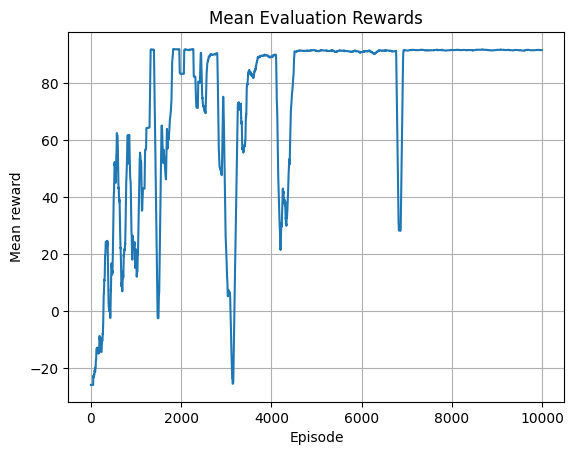

In [19]:
# Monte Carlo
mc_qTable, train_returns, mean_evaluation_rewards  = mcLearning(
    env,
    gamma=0.99,
    alpha=0.2,
    initial_epsilon=0.8,
    epsilon_decay=0.999,
    n_episodes=10000,     
    eval_episodes=5,
    first_visit=True
)


In [20]:
# Print Q values
for action in range(env.action_space.n): # For all actions in the action space (4)
    print(F"Q(s, a = {action}) | Action {env.ACTION_NAMES[action]}")
    print(mc_qTable[:, :, action])

Q(s, a = 0) | Action UP
[[-20.57838058   1.91074661  20.2419271   32.51112487  20.35200178]
 [-17.19097497  84.99117983   0.          31.35141571  26.3712068 ]
 [  0.           0.          28.83679139  42.5219955   61.22615476]
 [ -2.61864304   0.          53.97592762   0.          90.86217556]
 [ -3.81437168  53.31956619  65.07333695  87.51704646   0.        ]]
Q(s, a = 1) | Action LEFT
[[-20.65650788  -1.22333647  24.46628961  27.56839278  28.66476714]
 [-17.30354828   5.15201977   0.          36.98416747  91.58037156]
 [  0.           0.          31.51946852  39.40316978  72.59306661]
 [ -2.41186205   0.          42.40844574   0.          82.21974441]
 [  7.17222262  56.57205855  78.22800793  77.82943407   0.        ]]
Q(s, a = 2) | Action DOWN
[[-20.66861433   1.30693858  34.27381393  90.76307763  20.81267449]
 [-16.65869044   5.84134067   0.          93.19409177  30.2607827 ]
 [  0.           0.          29.09009646  39.26764793  96.76100041]
 [ 44.19952796   0.          48.577418

In [21]:
mean_cum_rew = evaluateQTable(env, mc_qTable, render=True)

# --------- Episode n.1 --------- # 
Action taken: RIGHT
|___| A |___|___|___|
|___|___|///|___|___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: RIGHT
|___|___| A |___|___|
|___|___|///|___|___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: RIGHT
|___|___|___| A |___|
|___|___|///|___|___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___|///| A |___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___|///|___|___|
|///|///|___| A |___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: RIGHT
|___|___|___|___|___|
|___|___|///|___|___|
|///|///|___|___| A |
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action take

# Q-learning

![](imgs/q-learning.png)

In [ ]:
def qLearning(env, alpha=0.2, gamma=0.99, initial_epsilon=0.8, n_episodes=500, eval_episodes=5, seed=None, plot_curve=True):
    
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    train_returns = []
    # We start by defining the dimensions of the Q-Table
    #
    # Basically what we do here is that we take the state space dimensions (5x5) through
    # env.observation_space.nvec and we append it to this list "q_table_size".
    # Then, we do the same for the action_space (4).
    #
    # In the end, we will have a list with [5, 5, 4], which we'll use to initialize our Q-Table.
    q_table_size = []
    for size in env.observation_space.nvec: # 5 x 5
        q_table_size.append(size)
    q_table_size.append(env.action_space.n) # 4

    print("Q-Table size: ", q_table_size) # [5, 5, 4]

    # Initialize Q-Table as a [5, 5, 4] Numpy array.
    # This means that we will have a 5 x 5 array for each single action.
    q_table = np.zeros(q_table_size) 

    # Initialize some variables (Epsilon, rewards, etc)
    epsilon = initial_epsilon # Init epsilon
    received_first_reward = False
    evaluation_rewards = [] # Evaluation
    mean_evaluation_rewards = [] # Mean Evaluation
    window = 100

    env.verbose = False # Silence the prints about agent diagonal actions, etc.

    # For all the episodes
    for ep in range(n_episodes):
        state = env.reset()
        done = False
        ep_return = 0.0
        while not done: # "until S is terminal"
            # Choose the action with epsilon-greedy strategy
            # We can use random.random() to generate a random number between 0 and 1
            # Let's remember that with 1-ϵ we choose the argmax of Q, otherwise 
            # we'll choose a random action from the action space.
            
            action = ... # TODO

            # Run a simulation step in the environment with the chosen action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_return += float(reward) # bookkeeping
            #env.render()

            # update the Q-Table using the transition
            q_table[...] = ... # TODO

            if not received_first_reward and reward > 0:
                received_first_reward = True
                print("Received first reward at episode ", ep)

            state = next_state # S <- S'

        train_returns.append(ep_return) #bookkeeping
        
        # Update current epsilon only if we received the first reward
        if received_first_reward:
            epsilon = 0.9999 * epsilon

        # Evaluate the Q-Table and place it in the evaluation_rewards list
        evaluation_rewards.append(evaluateQTable(env, q_table, n_episodes=eval_episodes)) # Mean reward with this Q-Table over 5 episodes
        mean_evaluation_rewards.append(mean(evaluation_rewards[-window:]))      # [-window:] = We take the [-100:end] array. Basically all the 100 values

    if plot_curve:            
        plt.title("Mean Evaluation Rewards")
        plt.xlabel('Episode')
        plt.ylabel('Mean reward')
        plt.grid(True)
        plt.plot(mean_evaluation_rewards)

    print("Training finished in {} episodes\n".format(n_episodes))
    return q_table, train_returns, mean_evaluation_rewards

Q-Table size:  [5, 5, 4]
Received first reward at episode  2
Training finished in 10000 episodes



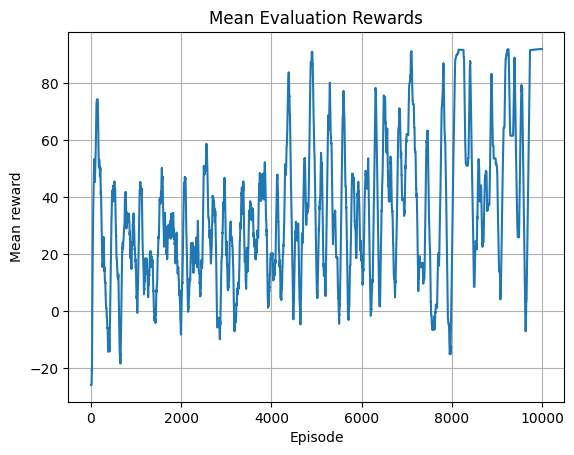

In [ ]:
# Q-learning
qTable, train_returns, mean_evaluation_rewards = qLearning(env, alpha=0.2, initial_epsilon=0.8, n_episodes=10000)

In [22]:
# Print Q values
for action in range(env.action_space.n): # For all actions in the action space (4)
    print(F"Q(s, a = {action}) | Action {env.ACTION_NAMES[action]}")
    print(qTable[:, :, action])

Q(s, a = 0) | Action UP
[[82.82276016 84.98052492 87.27081045 89.0002696  90.53817419]
 [82.68607152 85.28199041  0.         88.5377142  90.26886325]
 [ 0.          0.         65.15839233 89.89350952 92.43447345]
 [41.88456831  0.         67.52132309  0.         95.29773292]
 [51.63791161 57.81372488 60.87457246 96.24898232  0.        ]]
Q(s, a = 1) | Action LEFT
[[82.73334036 82.95006546 84.90190569 87.30028042 88.9156195 ]
 [73.58890554 76.67238767  0.         88.37163379 90.91769057]
 [ 0.          0.         68.97496616 71.19681143 93.30119843]
 [40.86726781  0.         60.98619664  0.         97.40295637]
 [54.8639652  58.78276357 63.41292802 82.16565323  0.        ]]
Q(s, a = 2) | Action DOWN
[[80.86880046 83.50608222 86.39917071 90.7648871  92.11826164]
 [64.97388421 74.52452159  0.         88.98155862 94.24490075]
 [ 0.          0.         71.79617502 89.71699178 97.02508741]
 [54.48022395  0.         71.14024598  0.         99.78358033]
 [47.99319937 58.15260751 65.95189777 96

### Evaluate policy

Render the Agent behaviour

In [23]:
mean_cum_rew = evaluateQTable(env, qTable, render=True)

# --------- Episode n.1 --------- # 
Action taken: RIGHT
|___| A |___|___|___|
|___|___|///|___|___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: RIGHT
|___|___| A |___|___|
|___|___|///|___|___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: RIGHT
|___|___|___| A |___|
|___|___|///|___|___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___|///| A |___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: RIGHT
|___|___|___|___| A |
|___|___|///|___|___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action taken: DOWN
|___|___|___|___|___|
|___|___|///| A |___|
|///|///|___|___|___|
|___|///|___|///|___|
|___|___|___|___| G |


Termination reached: False
Action take

# Variance

| A |___|///|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|///|///|___|
|___|___|___|///| G |


Q-Table size:  [5, 5, 4]
Received first reward at episode  19
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  16
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  26
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  33
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  21
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  5
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  16
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  0
Training finished in 1000 episodes

Q-Table size:  [5, 5, 4]
Received first reward at episode  14
Training finished in 1000 episodes

Q-Table 

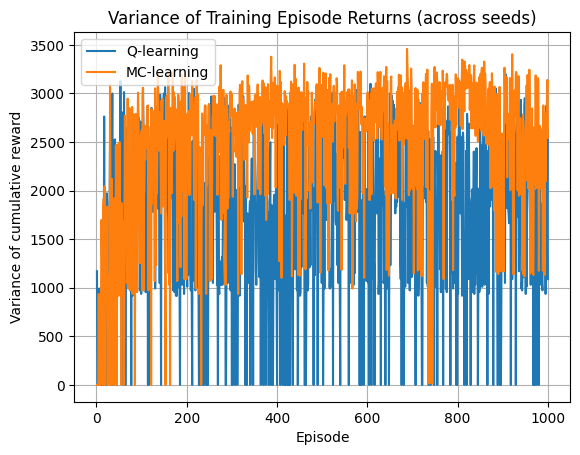

In [27]:
import numpy as np
from matplotlib import pyplot as plt

# Build a fresh env with the SAME params for every run (adjust to your constructor)
def make_env():
    random.seed(0)
    np.random.seed(0)
    env = NonDeterministicGridWorld(width=5, height=5, p=0.8, reward_type="sparse", obstacles=True, verbose=False)
    env.reset()
    env.render()
    return env

seeds = list(range(10))  # increase if you want smoother variance curves
n_episodes = 1000

ql_runs = []
mc_runs = []

env = make_env()

# Q-learning runs
for s in seeds:
    env.reset()
    qQ, qR, _ = qLearning(env, alpha=0.2, gamma=0.99, initial_epsilon=0.8, n_episodes=n_episodes, seed=s, plot_curve=False)
    ql_runs.append(np.asarray(qR, dtype=float))

# MC runs
for s in seeds:
    env.reset()
    mQ, mR, _ = mcLearning(env, gamma=0.99, alpha=0.2, initial_epsilon=0.8, n_episodes=n_episodes, seed=s, plot_curve=False)
    mc_runs.append(np.asarray(mR, dtype=float))

# Stack and compute per-episode variance across seeds
ql_mat = np.vstack(ql_runs)   # shape: (num_seeds, n_episodes)
mc_mat = np.vstack(mc_runs)

ql_var = np.var(ql_mat, axis=0)
mc_var = np.var(mc_mat, axis=0)

x = np.arange(1, n_episodes+1)

plt.title("Variance of Training Episode Returns (across seeds)")
plt.xlabel("Episode")
plt.ylabel("Variance of cumulative reward")
plt.plot(x, ql_var, label="Q-learning")
plt.plot(x, mc_var, label="MC-learning")
plt.grid(True)
plt.legend()
plt.show()
